## Data 620 Project 2
### 2-Node Network Analysis
Jit Seneviratne and Sheryl Piechocki 
June 27, 2020

Video clip 

**Dataset**
The data used in this project is from a database compiled by Olival, K., Hosseini, P., Zambrana-Torrelio, C. et al. It contains  2,805 mammal–virus associations, including 754 mammal species 586 unique viral species.  Also included is a measure of detection for the association that relates to the quality of the association.  Included attributes are virus genus and mammal classification of wild vs. domestic.  

Source: Olival, K., Hosseini, P., Zambrana-Torrelio, C. et al. Host and viral traits predict zoonotic spillover from mammals. *Nature* 546, 646–650 (2017). https://doi.org/10.1038/nature22975  
Data: https://zenodo.org/record/807517#.XveDWPXPxPY

**Analysis**
The association, virus, and hosts files will be loaded for analysis.  Common names will be mapped to hosts.  The bipartite network will be projected onto both a hosts and virus sub-network.  Hosts and virus networks will be analyzed using various centrality measures and reduced to visualize clusters.


In [75]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt

### Load the data

In [76]:
data_df = pd.read_csv("data_files/associations.csv")
data_df.head()

,vVirusNameCorrected,hHostNameFinal,WildDomInReference,DetectionMethod,DetectionQuality,Reference
0,Andes_virus,Abrothrix_longipilis,wild,PCR,2.0,Medina et al. 2009
1,Andes_virus,Abrothrix_olivaceus,wild,Antibodies,0.0,Sosa-Estani et al. 2002
2,Andes_virus,Abrothrix_sanborni,wild,Antibodies,0.0,Padula et al. 2004
3,African_horse_sickness_virus,Acinonyx_jubatus,wild,bcELISA,0.0,Alexander et al. 1995
4,Bluetongue_virus,Acinonyx_jubatus,wild,Antibodies,0.0,Alexander et al. 1994


In [77]:
virus_df = pd.read_csv("data_files/viruses.csv")
virus_df.head()

,vVirusNameCorrected,vOrder,vFamily,vSubfamily,vGenus,vIsTypeSpecies,vICTVnumber,ReverseZoonoses,IsHoSa,IsHoSa.stringent,...,vWOKcites,vPubMedCites,vCytoReplicTF,vSegmentedTF,vVectorYNna,vSSoDS,vDNAoRNA,vEnvelope,IsZoonotic,IsZoonotic.stringent
0,Adelaide_River_virus,Mononegavirales,Rhabdoviridae,NaN,Ephemerovirus,0,NaN,0,0,0,...,6,7,True,False,Y,SS,RNA,enveloped,0,0
1,Adeno-associated_virus-1,Unassigned,Parvoviridae,Parvovirinae,Dependovirus,0,00.050.1.03.002.,0,1,0,...,54,14,False,False,NaN,SS,DNA,non-enveloped,1,0
2,Adeno-associated_virus-2,Unassigned,Parvoviridae,Parvovirinae,Dependovirus,1,00.050.1.03.001.,1,1,1,...,573,381,False,False,NaN,SS,DNA,non-enveloped,1,0
3,Adeno-associated_virus-5,Unassigned,Parvoviridae,Parvovirinae,Dependovirus,0,NaN,0,1,1,...,4,4,False,False,NaN,SS,DNA,non-enveloped,0,0
4,African_green_monkey_polyomavirus,Unassigned,Polyomaviridae,NaN,Polyomavirus,NaN,NaN,0,1,0,...,1,0,True,False,N,DS,DNA,non-enveloped,1,0


In [78]:
host_df = pd.read_csv('data_files/hosts.csv', 
                      header=0,
                      usecols=[0,14])
host_df['Common_names_Eng'] = host_df['Common_names_Eng'].apply(lambda x: x.split(',')[0] if not pd.isnull(x) else x)

host_df.loc[host_df['Common_names_Eng'].isnull(),
            'Common_names_Eng'] = host_df['hHostNameFinal']

host_df.head()

,hHostNameFinal,Common_names_Eng
0,Abrothrix_longipilis,Long-haired Akodont
1,Abrothrix_olivaceus,Olive Grass Mouse
2,Abrothrix_sanborni,Sanborn's Grass Mouse
3,Acinonyx_jubatus,Cheetah
4,Aepyceros_melampus,Black-faced Impala


In [79]:
data_df['DetectionQuality'] = data_df['DetectionQuality'].apply(lambda x: .1 if x == 0 else x)
data_df = data_df.dropna(subset=['DetectionQuality'])

In [80]:
data_df['DetectionQuality'].isnull().value_counts()

False    2804
Name: DetectionQuality, dtype: int64

In [81]:
host_map = {k:v for k,v in zip(host_df['hHostNameFinal'], host_df['Common_names_Eng'])}

In [82]:
data_df['HostName'] = data_df['hHostNameFinal'].map(host_map)

Check for nulls

In [83]:
data_df['HostName'].isnull().value_counts()

False    2804
Name: HostName, dtype: int64

In [84]:
data_unstack = data_df.groupby(['vVirusNameCorrected',
                                 'HostName'])[['DetectionQuality']].sum().unstack().fillna(0)

data_unstack.columns = list(data_unstack.columns.get_level_values(1))
data_unstack.index = list(data_unstack.index.get_level_values(0))

data_unstack.head(5)

,Aardwolf,Aba Roundleaf Bat,Abruzzo Chamois,Admiralty Flying-fox,African Buffalo,African Caracal,African Elephant,African Grass Rat,African Lion,African Marsh Rat,...,Yellow Ground Squirrel,Yellow Mongoose,Yellow Pygmy Rice Rat,Yellow-bellied Marmot,Yellow-bellied Pouched Bat,Yellow-necked Field Mouse,Yellow-pine Chipmunk,Yellow-spotted Brush-furred Rat,Yellowish Myotis,Yuma Myotis
Adelaide_River_virus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adeno-associated_virus-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adeno-associated_virus-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adeno-associated_virus-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
African_green_monkey_polyomavirus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create bipartite graph with hosts and viruses

In [85]:
B=nx.Graph()

B.add_nodes_from(data_df['vVirusNameCorrected'],
                 bipartite=0)

B.add_nodes_from(data_df['HostName'],
                 bipartite=1)

B.add_weighted_edges_from(
    [(row['vVirusNameCorrected'], 
      row['HostName'],
      row['DetectionQuality']) for idx, row in data_df.iterrows()])

domain_map = {k:v for k,v in zip(data_df['HostName'], data_df['WildDomInReference'])}
genus_map = {k:v for k,v in zip(virus_df['vVirusNameCorrected'], virus_df['vGenus'])}

for node in list(B.nodes):
    try:
        B.nodes[node]['domain'] = domain_map[node]
    except KeyError:
        B.nodes[node]['domain'] = 'None'
    try:
        B.nodes[node]['genus'] = genus_map[node]
    except KeyError:
        B.nodes[node]['genus'] = 'None'

In [86]:
B.number_of_nodes()

1339

In [87]:
B.number_of_edges()

2798

In [88]:
nx.is_connected(B)

False

![title](data_files/all.png)

### Create weighted projected graphs for hosts and viruses

In [89]:
virus = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
host = set(B) - virus
#host = {n for n, d in B.nodes(data=True) if d['bipartite']==1}

# project bipartite graph onto virus nodes keeping number of co-occurences, weighted degree
B_virus = nx.bipartite.weighted_projected_graph(B, virus)

# project bipartite graph onto host nodes keeping number of co-occurences, weighted degree
B_host = nx.bipartite.weighted_projected_graph(B, host, ratio=False)

### Host degrees
Humans have the by far the most virus connections (263), followed by cattle, horses, pigs, and sheep.

In [90]:
#list(B_host.degree())[:5]

h_deg = {k:v for k,v in dict(B.degree(host)).items()}
print('Host Degrees - Virus Associations')
for host, degree in sorted([(x,y) 
              for x,y in h_deg.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(host), 'Viruses:',degree)


Host Degrees - Virus Associations
Human - Viruses: 263
Bos_taurus - Viruses: 79
Equus_caballus - Viruses: 59
Eurasian Wild Pig - Viruses: 54
Ovis_aries - Viruses: 47


### Virus degrees
The rabies virus has by far the most hosts (140), followed by St. Louis encephalitis virus, bluetongue virus, vesicular stomatitis Indiana virus, and foot and mouth disease virus.

In [91]:
v_deg = {k:v for k,v in dict(B.degree(virus)).items()}
print('Virus Degrees - Host Associations')
for virus, degree in sorted([(x,y) 
              for x,y in v_deg.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(virus), 'Hosts:',degree)


Virus Degrees - Host Associations
Rabies_virus - Hosts: 140
St._Louis_encephalitis_virus - Hosts: 63
Bluetongue_virus - Hosts: 61
Vesicular_stomatitis_Indiana_virus - Hosts: 59
Foot-and-mouth_disease_virus - Hosts: 50


### Betweenness centrality
Betweenness centrality measures the extent to which a node is a bridge. Betweenness centrality measures the extent that the node is on the shortest path between other pairs of nodes in the network.
In the complete network, humans have the highest betweenness centrality of 0.547.  The rabies virus is second with 0.168.

In [92]:
bet_cent = {k:v for k,v in dict(nx.betweenness_centrality(B)).items()}
print('Betweenness Centrality ')
for host, vdegree in sorted([(x,y) 
              for x,y in bet_cent.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(host), 'Betweenness Centrality:',round(vdegree,3))

Betweenness Centrality 
Human - Betweenness Centrality: 0.547
Rabies_virus - Betweenness Centrality: 0.168
Bos_taurus - Betweenness Centrality: 0.078
Eurasian Wild Pig - Betweenness Centrality: 0.062
Vesicular_stomatitis_Indiana_virus - Betweenness Centrality: 0.055


### Host network betweenness centrality

In [93]:
h_bet_cent = {k:v for k,v in dict(nx.betweenness_centrality(B_host)).items()}
print('Host Network Betweenness Centrality ')
for host, vdegree in sorted([(x,y) 
              for x,y in h_bet_cent.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(host), 'Betweenness Centrality:',round(vdegree,3))

Host Network Betweenness Centrality 
Human - Betweenness Centrality: 0.377
Eurasian Wild Pig - Betweenness Centrality: 0.042
Bos_taurus - Betweenness Centrality: 0.04
Ovis_aries - Betweenness Centrality: 0.025
Equus_caballus - Betweenness Centrality: 0.025


### Virus network weighted degrees

In [94]:
v11_deg = {k:v for k,v in dict(B_virus.degree()).items()}
print('Virus Degrees - Connections to Other Viruses')
for virus, degree in sorted([(x,y) 
              for x,y in v11_deg.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(virus), 'Connections:',degree)


Virus Degrees - Connections to Other Viruses
Encephalomyocarditis_virus - Connections: 425
Rabies_virus - Connections: 401
Vesicular_stomatitis_Indiana_virus - Connections: 396
Borna_disease_virus - Connections: 390
Suid_herpesvirus_1 - Connections: 379


### Virus network degree centrality

In [95]:
v11_deg_cent = {k:v for k,v in dict(nx.degree_centrality(B_virus)).items()}
print('Virus Network Degree Centrality ')
for virus, vdegree in sorted([(x,y) 
              for x,y in v11_deg_cent.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(virus), 'Degree Centrality:',round(vdegree,3))

Virus Network Degree Centrality 
Encephalomyocarditis_virus - Degree Centrality: 0.726
Rabies_virus - Degree Centrality: 0.685
Vesicular_stomatitis_Indiana_virus - Degree Centrality: 0.677
Borna_disease_virus - Degree Centrality: 0.667
Suid_herpesvirus_1 - Degree Centrality: 0.648


In [96]:
#Code from textbook Social Network Analysis for Startups by Maksim Tsvetovat and Alexander Kouznetsov
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
    return g2

def island_method(g, iterations = 5):
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

### Virus islands analysis

In [97]:
# virus islands analysis
#cc = list(B_virus.subgraph(c) for c in nx.connected_components(B_virus))[0]
cc = list(B_virus.subgraph(c) for c in sorted(nx.connected_components(B_virus), key=len, reverse=True))[0]
islands = island_method(cc)

for i in islands:
    print(i[0], len(list(nx.degree(i[1]))), len(list(connected_component_subgraphs(i[1]))))

1 303 3
6 60 3
11 21 2
16 8 2
21 6 2
26 2 1


### Color-coded Virus Analysis

Colors indicate whether virus is a coronavirus or not

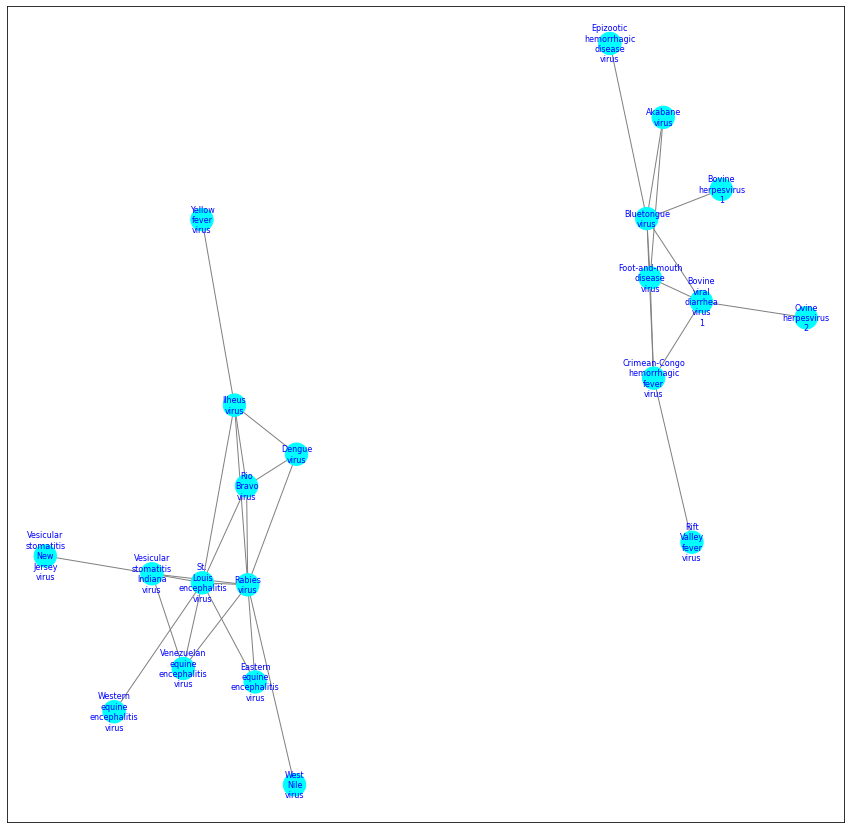

In [149]:
# use 11 for the threshold
v11 = trim_edges(B_virus,11)

genus_color = []
for node in list(v11.nodes):
    v11.nodes[node]['genus'] = genus_map[node]
    if genus_map[node] in ('Betacoronavirus', 'Coronavirus', 'Alphacoronavirus'):
        genus_color.append('lightblue')
    else: 
        genus_color.append('cyan')


plt.figure(figsize=(15,15))
pos = nx.spring_layout(v11, iterations = 25)
label_pos = {k:k.replace('_','\n').replace(' ','\n') for k,v in pos.items()}
weights=[edata['weight'] for f,t,edata in v11.edges(data=True)]
nx.draw_networkx_nodes(v11, pos, node_color=genus_color, node_size=500)
nx.draw_networkx_edges(v11, pos,  edge_color='gray')
nx.draw_networkx_labels(v11, pos, label_pos, font_size=8, font_color ='blue')

plt.show()

It looks like none of the most common virus clusters contain a coronavirus

### Host network weighted degrees

In [99]:
h11_deg = {k:v for k,v in dict(B_host.degree()).items()}
print('Host Degrees - Weighted Connections to Other Hosts')
for host, degree in sorted([(x,y) 
              for x,y in h11_deg.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(host), 'Connections:',degree)


Host Degrees - Weighted Connections to Other Hosts
Human - Connections: 646
Bos_taurus - Connections: 368
Equus_caballus - Connections: 345
Ovis_aries - Connections: 320
Canis_familiaris - Connections: 318


### Host network degree centrality

In [100]:
h11_deg_cent = {k:v for k,v in dict(nx.degree_centrality(B_host)).items()}
print('Host Network Degree Centrality ')
for host, vdegree in sorted([(x,y) 
              for x,y in h11_deg_cent.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(host), 'Degree Centrality:',round(vdegree,3))

Host Network Degree Centrality 
Human - Degree Centrality: 0.859
Bos_taurus - Degree Centrality: 0.489
Equus_caballus - Degree Centrality: 0.459
Ovis_aries - Degree Centrality: 0.426
Canis_familiaris - Degree Centrality: 0.423


### Host network closeness centrality  
Closeness centrality is a way of detecting nodes that are able to spread information very efficiently through a graph. Nodes with a high closeness centrality have the shortest distances to all other nodes.

In [101]:
h11_clos_cent = {k:v for k,v in dict(nx.closeness_centrality(B_host)).items()}
print('Host Network Closeness Centrality ')
for host, vdegree in sorted([(x,y) 
              for x,y in h11_clos_cent.items()], 
              key=lambda x: x[1], reverse=True)[:5]:
    print('{} -'.format(host), 'Closeness Centrality:',round(vdegree,3))

Host Network Closeness Centrality 
Human - Closeness Centrality: 0.87
Bos_taurus - Closeness Centrality: 0.648
Equus_caballus - Closeness Centrality: 0.634
Ovis_aries - Closeness Centrality: 0.62
Canis_familiaris - Closeness Centrality: 0.62


Humans, Cattle, Horses, Sheep, Goats

### Host islands analysis

In [102]:
cc = list(B_host.subgraph(c) for c in sorted(nx.connected_components(B_host), key=len, reverse=True))[0]
islands = island_method(cc)

for i in islands:
    print(i[0], len(list(nx.degree(i[1]))), len(list(connected_component_subgraphs(i[1]))))

1 367 1
7 49 1
13 13 1
19 8 1
25 6 1
31 4 1


### Color-coded Island Method

In [103]:
# use 7 for the threshold
h11 = trim_edges(B_host, 7)

wild_domestic_color = []
bat_non_bat_color = []
for node in list(h11.nodes):
    h11.nodes[node]['domain'] = domain_map[node]
    if domain_map[node] == 'wild':
        wild_domestic_color.append('lightblue')
    else:
        wild_domestic_color.append('cyan')
    if ('Bat'or 'Flying Fox') in node:
        bat_non_bat_color.append('lightblue')
    else:
        bat_non_bat_color.append('cyan')

### Infections Grouped by Wild Animals vs Domestic Animals

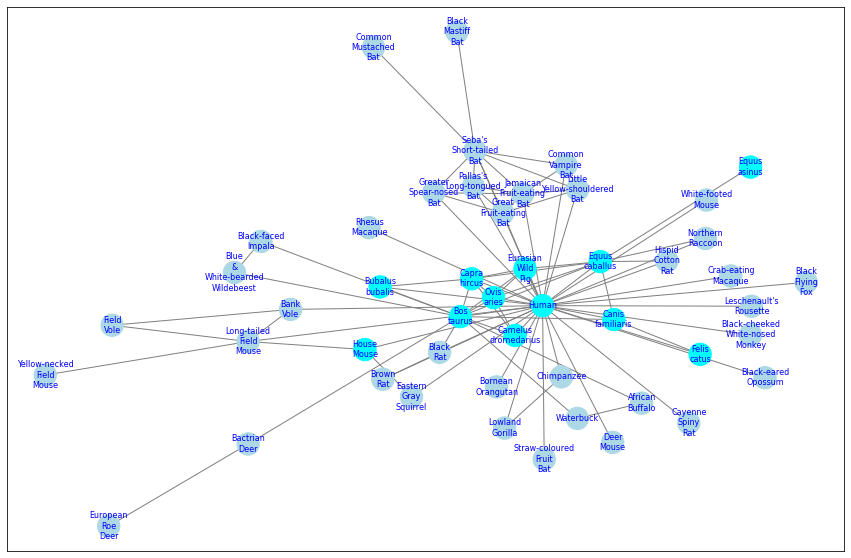

In [137]:
plt.figure(figsize=(15,10))
pos = nx.fruchterman_reingold_layout(h11, iterations = 20)
label_pos = {k:k.replace('_','\n').replace(' ','\n') for k,v in pos.items()}
nx.draw_networkx_nodes(h11, 
                       pos, 
                       node_color=wild_domestic_color, 
                       node_size=500)
nx.draw_networkx_edges(h11, pos,  edge_color=['gray'])
nx.draw_networkx_labels(h11, pos, label_pos, font_size=8, font_color ='blue')

plt.show()

### Infections from Bats vs Other Animals

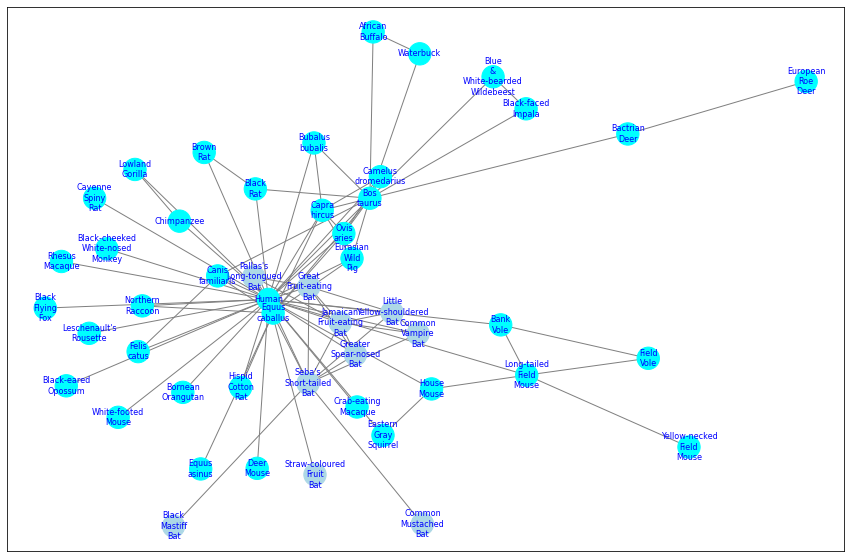

In [141]:
plt.figure(figsize=(15,10))
pos = nx.spring_layout(h11, iterations = 20)
label_pos = {k:k.replace('_','\n').replace(' ','\n') for k,v in pos.items()}
nx.draw_networkx_nodes(h11, 
                       pos, 
                       node_color=bat_non_bat_color, 
                       node_size=500)
nx.draw_networkx_edges(h11, pos,  edge_color=['gray'])
nx.draw_networkx_labels(h11, pos, label_pos, font_size=8, font_color ='blue')

plt.show()

In [142]:
coronavirus_filter = [(u,v) for u,v in B.edges if B.nodes[u]['genus'] in ('Betacoronavirus', 'Coronavirus', 'Alphacoronavirus')]
C = B.edge_subgraph(coronavirus_filter)

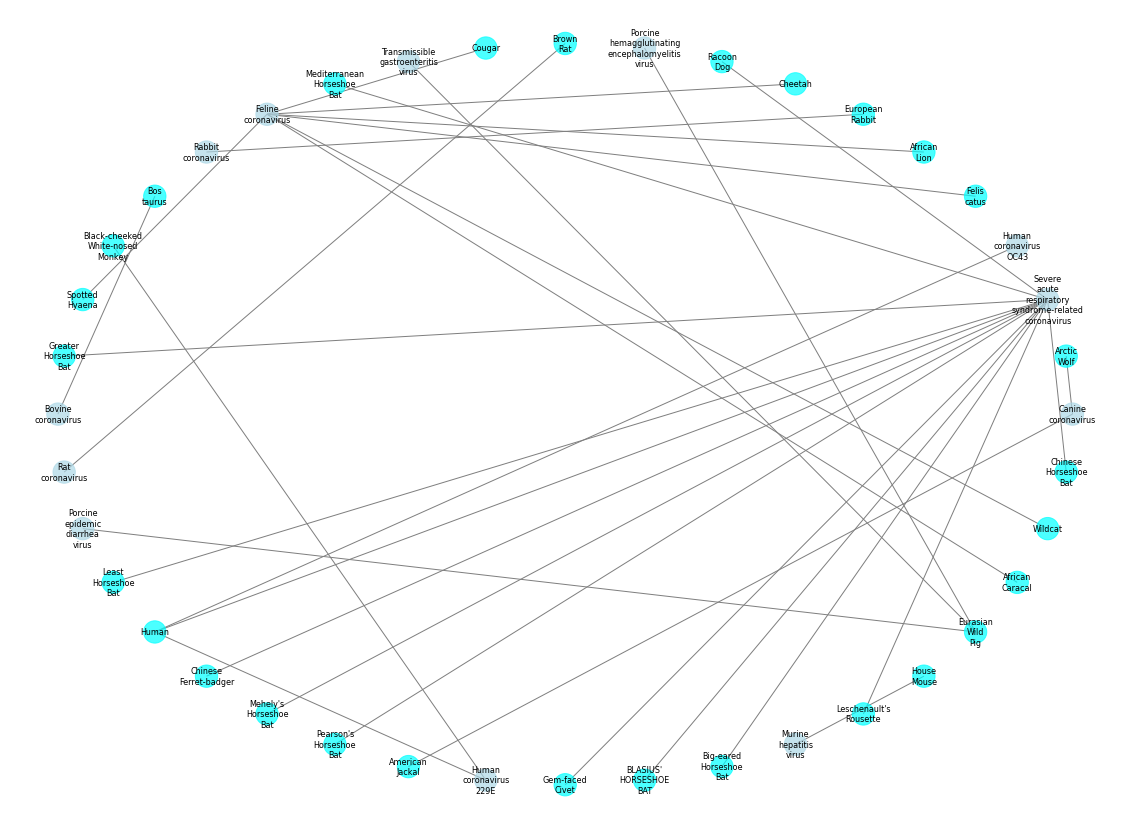

In [150]:
plt.figure(figsize=(20,15))
pos = nx.circular_layout(C)
label_pos = {k:k.replace('_','\n').replace(' ','\n') for k,v in pos.items()}

plt.axis('off')

animal_virus_color = []
for node in list(C.nodes):
    if C.nodes[node]['genus'] in ('Betacoronavirus', 'Coronavirus', 'Alphacoronavirus'):
        animal_virus_color.append('lightblue')
    else:
        animal_virus_color.append('cyan')

nx.draw_networkx_nodes(C, 
                       pos,
                       node_color=animal_virus_color, 
                       alpha=0.7, 
                       node_size=500)

nx.draw_networkx_edges(C, 
                       pos, 
                       edge_color='gray')

nx.draw_networkx_labels(C, 
                        pos,
                        label_pos,
                        font_size=8,
                        font_weight=10);

In [146]:
nx.write_gml(B, 'B.gml')
nx.write_gml(h11, 'h11.gml')
nx.write_gml(C, 'C.gml')